# Content and Objective

+ Show variance of estimation when estimating psd
+ Method: Get rectangular signal and noise, and perform psd estimation

In [1]:
# importing
import numpy as np
from scipy import signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Helper Functions

### Define Function for Estimating ACF

In [3]:
########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """
    
    N = np.size( y )
    r = np.zeros_like( y )
    
    # loop lags of acf
    for k in np.arange(0, N):
        
        temp = np.sum( y[k:N] * np.conjugate(y[0:(N-k)]) )

        # type of estimator
        if est_type == 'biased':
            r[k] = temp/N
        elif est_type == 'unbiased':
            r[k] = temp/(N-k)
        
    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])     
   
    return  np.append(r_reverse[0:len(r)-1], r)  

### Functions for estimating correlogram out of acf and periodogram

In [4]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex) 
        
    for p in np.arange(0, N):
        per += y[p] * np.exp( -1j * omega * (p+1) )
        
    per = ( abs(per)**2 )/ N
        
    return per   

    
########################
# correlogram estimator
########################
def find_correlogram(r, omega):
    """
    estimates correlogram out of the given acf at the frequencies specified in omega
    
    Remark: acf is assumed to be centered around 0
    
    IN: acf r, frequencies
    OUT: psd
    """
    corr = np.zeros(len(omega), dtype=complex)
  
    N = (len(r)+1)// 2

    # adding all terms
    for p in np.arange( -(N-1), (N-1)+1 ):
        corr += r[ p + (N-1) ] * np.exp( -1j * omega * p )
        
    # since there are minor numerical issues, resulting in negligible imaginary part, only real part is returned
    return np.real( corr )

# Parameters

In [10]:
# parameters: number of samples and according length of acf
N = int( 1e2 )
N_acf_range = np.arange( - N + 1, N, 1 )

# number of realizations for averaging    
N_real = int( 1e2 )

# number of freq. points and freq. range
N_freq = 512            
Ome = np.linspace(-np.pi, np.pi, N_freq)


# filtering noise?!
filtered = 1

### Loop for realizations

In [11]:
# initialize arrays for psd
psd_noise_per = np.empty( [ N_real, N_freq ] )
psd_noise_cor_biased = np.empty( [ N_real, N_freq ] )
psd_noise_cor_unbiased = np.empty( [ N_real, N_freq ] )

# avtivate parameter "filtered" in parameters if you like to see filtered noise
if filtered == 1:
    # filter parameters
    cutoff_freq = 1.0/4.0

    ripple_db = 60                      # ripples and transition width of the filter
    width = 1 / 5.0

    N_filter, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter
    
    taps = signal.firwin( N_filter, cutoff=cutoff_freq,  window=('kaiser', beta))

    
# loop for realizations
for _k in range( N_real ):
    
    # generate noise
        y = np.sqrt(2) * np.random.normal( 0.0, 1.0, N )

        # activate to have filtered noise
        if filtered == 1:
            y = signal.lfilter( taps, 1.0, y )
            y /= np.linalg.norm( y )
            

        # find acf estimations        
        acf_biased = est_acf( y, 'biased') 
        acf_unbiased = est_acf( y, 'unbiased') 
        
        # find periodogram by simple fft and abs()**2
        psd_noise_per[ _k, :] = find_periodogram( y, Ome)
        
        psd_noise_cor_biased[ _k, :] = find_correlogram( acf_biased, Ome)
        psd_noise_cor_unbiased[ _k, :] = find_correlogram( acf_unbiased, Ome)


# get mean and std along realizations
psd_noise_per_average = psd_noise_per.mean( axis=0 )
psd_noise_cor_biased_average = psd_noise_cor_biased.mean( axis=0 )    
psd_noise_cor_unbiased_average = psd_noise_cor_unbiased.mean( axis=0 )  


psd_noise_per_std = psd_noise_per.std( axis=0 )    
psd_noise_cor_biased_std = psd_noise_cor_biased.std( axis=0 )    
psd_noise_cor_unbiased_std = psd_noise_cor_unbiased.std( axis=0 )     
    

### Plotting

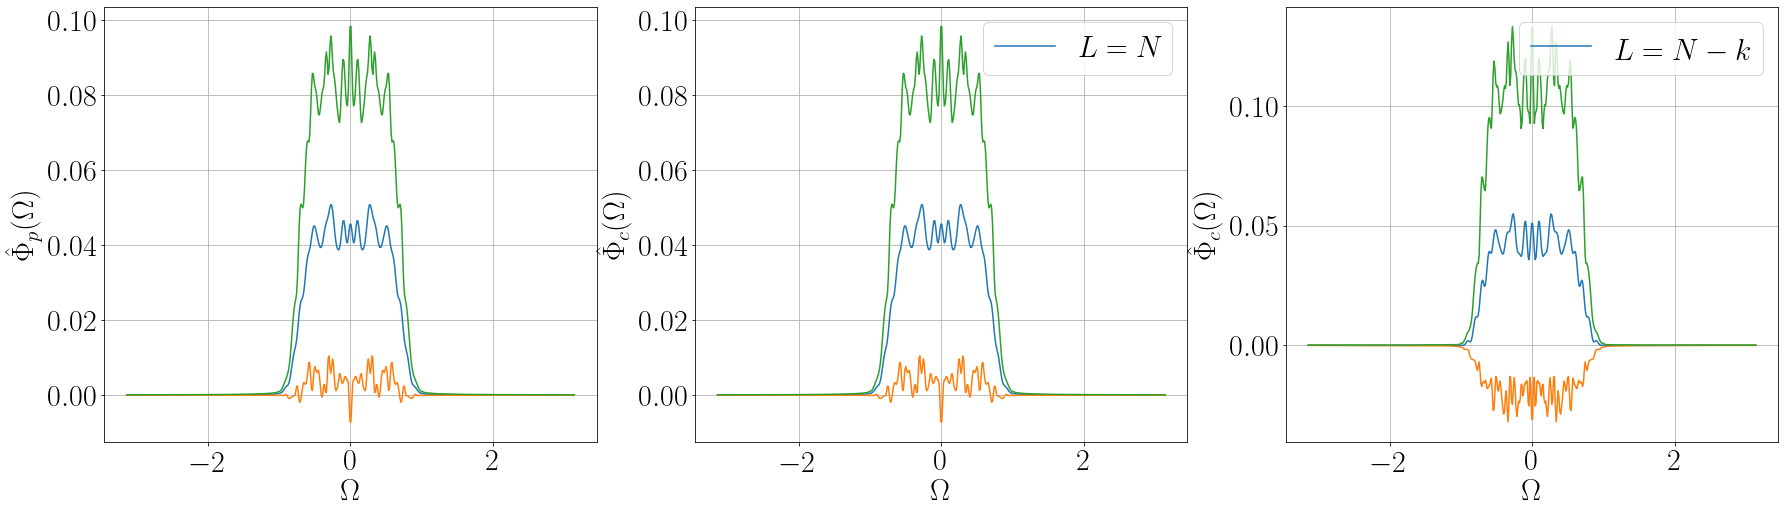

In [12]:
plt.subplot(131)  

plt.plot(Ome, psd_noise_per_average )      
plt.plot(Ome, psd_noise_per_average - psd_noise_per_std)          
plt.plot(Ome, psd_noise_per_average + psd_noise_per_std)          

plt.grid(True); 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_p(\Omega)$')   


plt.subplot(132)    
plt.plot(Ome, psd_noise_cor_biased_average, label='$L=N$')  
plt.plot(Ome, psd_noise_cor_biased_average - psd_noise_cor_biased_std)          
plt.plot(Ome, psd_noise_cor_biased_average + psd_noise_cor_biased_std)  

plt.grid(True); plt.legend(loc='upper right') 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_c(\Omega)$')       


plt.subplot(133)        
plt.plot(Ome, psd_noise_cor_unbiased_average, label='$L=N-k$')  
plt.plot(Ome, psd_noise_cor_unbiased_average - psd_noise_cor_unbiased_std)          
plt.plot(Ome, psd_noise_cor_unbiased_average + psd_noise_cor_unbiased_std)   

plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_c(\Omega)$')   
plt.grid(True); plt.legend(loc='upper right') 

**Note:**

+ Plots are showing mean along all realizations as well as mean +/- standard deviation